# Part 1. Initial assignment exploration

## CIFAR-10 Data Loading and Preprocessing 

In this week, we will be using thie CIFAR-10 dataset. Instead of drawing the data from an existing source, we will work with the initial release from the [site where CIFAR-10 is hosted](https://www.cs.toronto.edu/~kriz/cifar.html). Sufficient documentation should be present in the page. Instead of extracting the data manually with your mouse, first, write a simple script to download, extract and move the data into a appropriate folder. Also spare a thought for how you might want to not store this data in your git repository.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
import tarfile
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score

In [2]:
data_folder = Path("data/raw/")
file_to_open = data_folder / "cifar-10-python.tar.gz"

#### For downloading and unzipping of files. Uncomment code and run if needed.

In [3]:
# file_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# # URL of the file to be downloaded is defined as file_url 
# r = requests.get(file_url) # create HTTP response object 
  
# # send a HTTP request to the server and save 
# # the HTTP response in a response object called r 
# with open(file_to_open,'wb') as f: 
  
#     # Saving received content in 
#     # binary format 
  
#     # write the contents of the response (r.content) 
#     # to a new file in binary mode. 
#     f.write(r.content) 

In [4]:
# tar = tarfile.open(file_to_open, "r:gz")
# tar.extractall(path=data_folder)
# tar.close()

Next, write a simple script to load and transform multiple pieces of the dataset into a simple vector stored in memory. You should end with both train and test data. You can also split the data into train, val, and test sets. 

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
def getRawDictionary(fileName):
    batch = data_folder / "cifar-10-batches-py" / fileName
    data = unpickle(batch)
    return data

train_imgs = []
train_labels = []
test_imgs = []
test_labels = []

for i in range(1,6):
    data_batch = getRawDictionary("data_batch_" + str(i))
    if i == 1:
        train_imgs = data_batch[b'data']
        train_labels = np.asarray(data_batch[b'labels'])
    else:
        train_imgs = np.concatenate((train_imgs, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.asarray(data_batch[b'labels'])), axis=0)
    
test_batch = getRawDictionary("test_batch")
test_imgs = test_batch[b'data']
test_labels= np.asarray(test_batch[b'labels'])

In [7]:
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

In [8]:
label_dict = getRawDictionary("batches.meta")
label_names = label_dict[b'label_names']
label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

Finally, visualize some examples from the dataset. For each label class present, visualise a few images at random to see what our data looks like. Depending on the data type, you also may need to do some image pre-processing by reshaping the image data into rows.

b'cat'


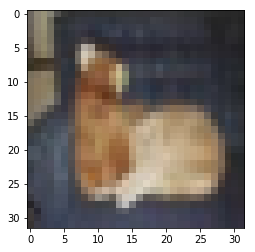

In [9]:
def drawImage(image_index):
    print(label_names[train_labels[image_index]])
    
    #visualizing train sample
    temp = train_imgs[image_index]
    
    # Since every row represents one example to re-map it to image we have to form three 32,32 matrix,
    #representing RGB values
    
    R = temp[0:1024].reshape(32,32)
    G = np.reshape(temp[1024:2048],newshape=(32,32))
    B = np.reshape(temp[2048:],newshape=(32,32))
    temp = np.dstack((R,G,B))   #for stacking all these 32,32 matrices.
    plt.imshow(temp)
    plt.show()

# Change the index to visualise different images in the dataframe
image_index = 17 
drawImage(image_index)

## k-Nearest Neighbor (kNN) exercise

In here, you will need to implement a KNN (K-nearest neighbours) classifier for the CIFAR-10 dataset. Apply best k-fold cross validation to find the best K and L (Euclidean or Manhattan distance) pair by plotting the resulting average accuracies and standard deviations and choosing the pair which produces the highest average accuracy first and lowest standard deviation second. Use this pair to find the accuracy per class and average accuracy on the testing set. Find out if grayscalse would produce a better accuracy than colored.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this part of exercise, you will implement these steps and understand the basic image classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

As a bonus, you may also wish to try manually creating features that you can put into such a classifier.

In [10]:
def toGrayScale(imgs):
    R = imgs[:,0:1024]
    G = imgs[:,1024:2048]
    B = imgs[:,2048:]

    imgs_grey = (R + G + B)/3
    return imgs_grey

train_imgs_grey = toGrayScale(train_imgs)
test_imgs_grey = toGrayScale(test_imgs)

In [11]:
# Subsetting dataset due to processing power limitation
sub_train_imgs = train_imgs[0:10000]
sub_train_labels = train_labels[0:10000]
sub_train_imgs_grey = train_imgs_grey[0:10000]

In [12]:
train_results_manhattan = []
train_std_manhattan = []
train_results_euclidean = []
train_std_euclidean = []

k_list = [5,10,15,20,25,30]

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, p=1)
    stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_score = cross_val_score(estimator=knn, X=sub_train_imgs, y=sub_train_labels, scoring='accuracy', cv=stratifiedKFold, n_jobs=-1)
    train_results_manhattan.append(np.mean(cv_score))
    train_std_manhattan.append(np.std(cv_score))

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    stratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_score = cross_val_score(estimator=knn, X=sub_train_imgs, y=sub_train_labels, scoring='accuracy', cv=stratifiedKFold, n_jobs=-1)
    train_results_euclidean.append(np.mean(cv_score))
    train_std_euclidean.append(np.std(cv_score))

Provide some reporting and visualization of KNN results in CIFAR-10

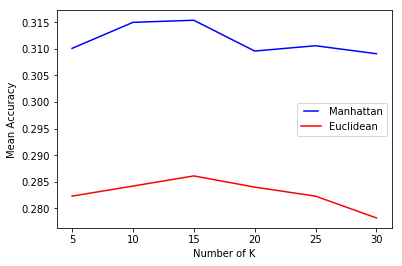

In [13]:
line1, = plt.plot(k_list, train_results_manhattan, 'b', label='Manhattan')
line2, = plt.plot(k_list, train_results_euclidean, 'r', label='Euclidean')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Mean Accuracy')
plt.xlabel('Number of K')
plt.show()

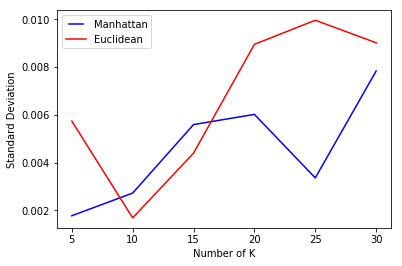

In [14]:
line1, = plt.plot(k_list, train_std_manhattan, 'b', label='Manhattan')
line2, = plt.plot(k_list, train_std_euclidean, 'r', label='Euclidean')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Standard Deviation')
plt.xlabel('Number of K')
plt.show()

In [15]:
# Color Dataset
neighbor = KNeighborsClassifier(n_neighbors=10, p=1)
neighbor.fit(sub_train_imgs,sub_train_labels)
neighbor.score(test_imgs,test_labels)

0.324

In [16]:
# Grayscale Dataset
neighbor_gray = KNeighborsClassifier(n_neighbors=10, p=1)
neighbor_gray.fit(sub_train_imgs_grey,sub_train_labels)
neighbor_gray.score(test_imgs_grey,test_labels)

0.2764